In [1]:
import warnings
warnings.filterwarnings("ignore")
from keras.engine.topology import Layer
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, GRU, Multiply, Reshape
from keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import pandas as pd
# from tcn import TCN
%matplotlib inline
from keras.layers import merge, Input, Dense, TimeDistributed, Lambda                                   
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPooling2D,MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Input, GlobalAveragePooling2D,AveragePooling2D, Add
from keras.optimizers import Adam, rmsprop
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm
MAX_SENT_LENGTH = 55
MAX_SENTS = 24
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from pandas import concat

std = StandardScaler()

In [4]:
import pandas as pd
#matplotlib inline
#参数初始化
discfile = '../data/data_wea_time_unify.csv'

data = pd.read_csv(discfile)

In [25]:
import h5py
import os

ground = h5py.File('../data/inte_g_12_linear.h5', 'r')
g = ground['X']

ele_zs = h5py.File('../data/inte_e_zs_12_new_linear.h5', 'r')
ezs = ele_zs['X']

ele_sd = h5py.File('../data/inte_e_sd_12_new_linear.h5', 'r')
esd = ele_sd['X']

In [26]:
g_m=[g,ezs,esd]

In [27]:
g_m=np.array(g_m).reshape(6064,16,16,3)
g=np.array(g).reshape(6064,16,16,1)

Train on 4850 samples, validate on 1213 samples
Epoch 1/40
 - 7s - loss: 47.4288 - val_loss: 34.3620
Epoch 2/40
 - 0s - loss: 33.8512 - val_loss: 28.1912
Epoch 3/40
 - 0s - loss: 33.8200 - val_loss: 28.1485
Epoch 4/40
 - 0s - loss: 32.7313 - val_loss: 30.1103
Epoch 5/40
 - 0s - loss: 32.7672 - val_loss: 28.9742
Epoch 6/40
 - 0s - loss: 32.4234 - val_loss: 27.8013
Epoch 7/40
 - 0s - loss: 32.3521 - val_loss: 27.6277
Epoch 8/40
 - 0s - loss: 32.1959 - val_loss: 28.0840
Epoch 9/40
 - 0s - loss: 32.0960 - val_loss: 28.2773
Epoch 10/40
 - 0s - loss: 31.9929 - val_loss: 27.8372
Epoch 11/40
 - 0s - loss: 31.8903 - val_loss: 27.6790
Epoch 12/40
 - 0s - loss: 31.7848 - val_loss: 27.5717
Epoch 13/40
 - 0s - loss: 31.6757 - val_loss: 27.4804
Epoch 14/40
 - 0s - loss: 31.5684 - val_loss: 27.4581
Epoch 15/40
 - 0s - loss: 31.4584 - val_loss: 27.2726
Epoch 16/40
 - 0s - loss: 31.3571 - val_loss: 27.3064
Epoch 17/40
 - 0s - loss: 31.2445 - val_loss: 27.1339
Epoch 18/40
 - 0s - loss: 31.1594 - val_los

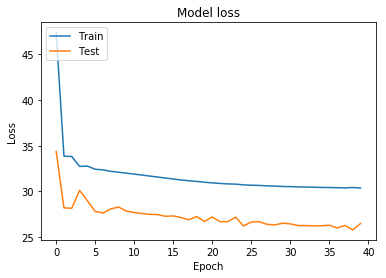

In [135]:
from keras.layers import LeakyReLU
inp=Input(shape=(16, 16,1))
out=Conv2D(filters=1, kernel_size=2, strides=1)(inp)
#     print(out.shape)
# out=BatchNormalization()(out)
out=Conv2D(filters=1, kernel_size=3, strides=1)(out)
# out=LeakyReLU('0.8')(out)
#     out=Activation('relu')(out)
out=MaxPooling2D(pool_size=(3, 3), strides=2)(out)
# print(out.shape)
# out=AveragePooling2D()(out)
#     out=GlobalAveragePooling2D()(out)
out=Flatten()(out)

out=Dense(3)(out)
out=Dense(1)(out)
tra=Model(inputs=inp, outputs=out)
tra.compile(optimizer=Adam(lr=0.001, beta_1=0.99, beta_2=0.999, decay=0.0006),
                        loss='mae')
history=tra.fit(g[:6063],data['PM25_mean'][1:], epochs=40, batch_size=68,verbose=2,validation_split=0.2,shuffle=True)
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [136]:
tra.predict(g)

array([[ 34.90504074],
       [ 31.36835098],
       [ 38.73972702],
       ..., 
       [ 32.55091476],
       [ 34.87251663],
       [ 30.53468132]], dtype=float32)

In [137]:
tra.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 1)         5         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 1)         10        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 1)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 111       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 4         
Total para

In [169]:
from keras.models import load_model

tra.save('tra_TFM.h5')  

## 24h时间变化特征


In [138]:
gg_g=[]

for i in range(24):
    gg=np.array(g[i]).reshape(1,16,16,1)
    gg_g.append(np.mean(gg))
    
print(gg_g)

[7.6944141, 7.9767895, 7.9894667, 8.4385338, 8.5764713, 8.5974464, 6.6877751, 8.3697195, 12.805021, 14.95537, 12.593945, 11.071941, 10.36893, 10.184487, 10.709339, 10.803516, 10.887819, 11.83437, 14.4537, 13.543304, 10.598665, 9.5020313, 8.8473072, 8.2672291]


In [147]:
rr=[]
for i in range(24):
    gg=np.array(g[i]).reshape(1,16,16,1)
    f = K.function(tra.inputs, [tra.get_layer('dense_27').output])

    r = f([gg])
    rr.append(-np.mean(r))
#     rr.append((r))


In [148]:
g_new=np.squeeze(r)
np.save('gg_new.npy',g_new)

[22.048548,
 19.72994,
 23.191263,
 19.674797,
 19.429081,
 20.703831,
 23.678198,
 23.478577,
 25.468596,
 24.909996,
 21.716431,
 21.136038,
 22.644836,
 24.087334,
 22.699898,
 23.264467,
 25.76037,
 25.550154,
 26.031713,
 24.597076,
 23.741899,
 23.908045,
 25.622801,
 24.378557]

In [139]:
np.array(data['PM25_mean'][1:25])

array([  8.889,   6.111,   7.625,   6.5  ,   5.25 ,   7.75 ,   7.889,
         8.667,   8.625,   8.125,  10.625,  12.375,   9.667,  11.444,
        15.   ,  22.125,  22.111,  20.444,  20.444,  21.667,  18.333,
        16.333,  17.222,  14.889])

## 空间变化特征

In [149]:
gg_g=[]

for i in range(24):
    gg=np.array(g[i]).reshape(1,16,16,1)
    gg_g.append(np.mean(gg))
    
print(gg_g)

[7.6944141, 7.9767895, 7.9894667, 8.4385338, 8.5764713, 8.5974464, 6.6877751, 8.3697195, 12.805021, 14.95537, 12.593945, 11.071941, 10.36893, 10.184487, 10.709339, 10.803516, 10.887819, 11.83437, 14.4537, 13.543304, 10.598665, 9.5020313, 8.8473072, 8.2672291]


In [154]:
gg_g=[]

for i in range(24):
    gg=np.array(g[i])
    gg_g.append((gg))
f = K.function(tra.inputs, [tra.get_layer('max_pooling2d_3').output])
g_new=np.mean(gg_g,axis=0)
gg_g=g_new.reshape(1,16,16,1)
r = f([gg_g])    
np.shape(r)

(1, 1, 6, 6, 1)

In [155]:
g_new=np.squeeze(r)
np.save('gg_new3.npy',g_new)

## 周末和工作日的时间变化

In [164]:
workday_24hour = [[] for i in range(24)]
weekendday_24hour = [[] for i in range(24)]

for i in range (g.shape[0]):
    if data.loc[i]['week'] == 7 or data.loc[i]['week'] ==6:
        hour = int(data.loc[i]['hour'])
        weekendday_24hour[hour].append(g[i])
        
    else:
        hour = int(data.loc[i]['hour'])
        weekendday_24hour[hour].append(g[i])

In [165]:
np.shape(np.squeeze(weekendday_24hour[0]))

(256, 16, 16)

In [166]:
rr=[]
f = K.function(tra.inputs, [tra.get_layer('dense_27').output])
for i in range(24):
    gg=np.array(np.mean(weekendday_24hour[i],axis=0))
#     gg_g.append((gg))
    
#     g_new=np.mean(gg_g,axis=0)
    gg_g=gg.reshape(1,16,16,1)
    r = f([gg_g])    
    rr.append(-np.mean(r))

In [167]:
rr

[24.256231,
 22.092321,
 22.424173,
 22.354345,
 22.396357,
 22.503714,
 23.637489,
 25.011908,
 27.874781,
 25.583038,
 24.58161,
 25.425119,
 25.351419,
 25.269892,
 24.947992,
 25.535606,
 26.120554,
 26.602438,
 26.807837,
 25.023523,
 24.825005,
 24.604296,
 24.393417,
 24.82049]

In [ ]:
g_new=np.squeeze(rr)
np.save('gg_new3.npy',g_new)

## 卷积池化

In [33]:
gg=np.array(np.mean(g, axis=0)).reshape(1,16,16,1)
f = K.function(tra.inputs, [tra.get_layer('conv2d_10').output])

r = f([gg])

In [37]:
rr=np.squeeze(r)

In [39]:
np.save('rr.npy',rr)

In [40]:
f = K.function(tra.inputs, [tra.get_layer('leaky_re_lu_8').output])

rl = f([gg])

In [42]:
rll=np.squeeze(rl)

In [43]:
np.save('rll.npy',rll)

In [44]:
f = K.function(tra.inputs, [tra.get_layer('average_pooling2d_8').output])

ra = f([gg])

In [45]:
raa=np.squeeze(ra)
np.save('raa.npy',raa)

In [46]:
f = K.function(tra.inputs, [tra.get_layer('dense_13').output])

rd = f([gg])

In [48]:
rd
rdd=np.squeeze(rd)

In [125]:
workday_24hour = [[] for i in range(24)]
weekendday_24hour = [[] for i in range(24)]

for i in range (g.shape[0]):
    if data.loc[i]['week'] == 7 or data.loc[i]['week'] ==6:
        hour = int(data.loc[i]['hour'])
        weekendday_24hour[hour].append(g[i])
        
    else:
        hour = int(data.loc[i]['hour'])
        workday_24hour[hour].append(g[i])

In [117]:
gg_g=[]

for i in range(24):
    gg=np.array(g[i]).reshape(1,16,16,1)
    gg_g.append(np.mean(gg))
    
print(gg_g)

[7.6944141, 7.9767895, 7.9894667, 8.4385338, 8.5764713, 8.5974464, 6.6877751, 8.3697195, 12.805021, 14.95537, 12.593945, 11.071941, 10.36893, 10.184487, 10.709339, 10.803516, 10.887819, 11.83437, 14.4537, 13.543304, 10.598665, 9.5020313, 8.8473072, 8.2672291]


In [132]:
gg_g=[]

for i in range(24):
    gg=np.array(g[i])
    gg_g.append((gg))
f = K.function(tra.inputs, [tra.get_layer('max_pooling2d_1').output])
g_new=np.mean(gg_g,axis=0)
gg_g=g_new.reshape(1,16,16,1)
r = f([gg_g])    
np.shape(r)

(1, 1, 6, 6, 1)

In [133]:
g_new=np.squeeze(r)
np.save('gg_new.npy',g_new)

In [ ]:
np.

In [122]:
rr=[]
for i in range(24):
    gg=np.array(g[i]).reshape(1,16,16,1)
#     print(np.mean(gg))
    f = K.function(tra.inputs, [tra.get_layer('conv2d_14').output])

    r = f([gg])
#     rr.append(np.mean(r))
    rr.append((r))


In [123]:
print(rr)

[[array([[[[  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [-10.80843544],
         [-24.62863541],
         [-19.0928936 ],
         [  2.60327482],
         [  1.85343003],
         [  0.90593308],
         [  0.90593308]],

        [[  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [ -2.31639218],
         [-11.34806061],
         [-20.24207306],
         [ -8.17982197],
         [ -0.32032162],
         [  0.90593308],
         [  0.90593308]],

        [[  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  0.90593308],
         [  1.19410777],
         [  4.10203791],
         [  5.54237366],
         [  4.7806201 ],
         [  1.65618491],
         [ -0.69121

         [  3.07499003]]]], dtype=float32)]]


In [111]:
np.array(data['PM25_mean'][0:24])

array([ 12.111,   8.889,   6.111,   7.625,   6.5  ,   5.25 ,   7.75 ,
         7.889,   8.667,   8.625,   8.125,  10.625,  12.375,   9.667,
        11.444,  15.   ,  22.125,  22.111,  20.444,  20.444,  21.667,
        18.333,  16.333,  17.222])

In [56]:
data['PM25_mean']

0        12.111
1         8.889
2         6.111
3         7.625
4         6.500
5         5.250
6         7.750
7         7.889
8         8.667
9         8.625
10        8.125
11       10.625
12       12.375
13        9.667
14       11.444
15       15.000
16       22.125
17       22.111
18       20.444
19       20.444
20       21.667
21       18.333
22       16.333
23       17.222
24       14.889
25       17.000
26       15.556
27       14.778
28       16.556
29       11.778
         ...   
6034     44.556
6035     36.667
6036     33.444
6037     34.889
6038     37.444
6039     51.444
6040     57.667
6041     58.889
6042     60.444
6043     63.556
6044     69.000
6045     75.111
6046     84.556
6047     90.444
6048     91.444
6049     97.333
6050    100.222
6051     82.333
6052     68.333
6053     59.778
6054     58.000
6055     60.222
6056     62.778
6057     75.556
6058     86.111
6059     87.111
6060     85.444
6061     60.111
6062     46.556
6063     43.556
Name: PM25_mean, Length:

In [53]:
from IPython.display import display, HTML
from heatmap import html_heatmap
display(HTML(html_heatmap([str(i) for i in range(3)], rdd)))

In [95]:
import h5py
import os

ground = h5py.File('../data/inte_g_12_linear.h5', 'r')
gg = ground['X']

ele_zs = h5py.File('../data/inte_e_zs_12_new_linear.h5', 'r')
ezs = ele_zs['X']

ele_sd = h5py.File('../data/inte_e_sd_12_new_linear.h5', 'r')
esd = ele_sd['X']

g_m=[]
for i in range(1,25):
    locals()['g'+str(i)]=gg[i-1:5800+i]
    
    g_m.append(locals()['g'+str(i)])
g_m=(np.array(g_m).swapaxes(0,1))
g_m=g_m.reshape(5801, 24, 16,16,1)

ezs_m=[]
for i in range(1,25):
    locals()['ezs'+str(i)]=ezs[i-1:5800+i]
    
    ezs_m.append(locals()['ezs'+str(i)])
ezs_m=(np.array(ezs_m).swapaxes(0,1))

ezs_m=ezs_m.reshape(5801, 24, 16,16,1)

esd_m=[]
for i in range(1,25):
    locals()['esd'+str(i)]=esd[i-1:5800+i]
    
    esd_m.append(locals()['esd'+str(i)])
esd_m=(np.array(esd_m).swapaxes(0,1))

esd_m=esd_m.reshape(5801, 24, 16,16,1)

ge_m=[ezs_m,esd_m,g_m]

ge_m=np.array(ge_m).reshape(5801, 24, 16,16,3)

In [105]:
np.shape(gg)

(6064, 16, 16)

In [16]:
from keras.layers import LeakyReLU
inp=Input(shape=(16, 16,1))
out=Conv2D(filters=1, kernel_size=2, strides=1)(inp)
#     print(out.shape)
out=BatchNormalization()(out)
out=LeakyReLU('0.1')(out)
#     out=Activation('relu')(out)
# out=MaxPooling2D(pool_size=(3, 3), strides=2)(out)
# print(out.shape)
out=AveragePooling2D()(out)
#     out=GlobalAveragePooling2D()(out)
out=Flatten()(out)

out=Dense(3)(out)
out=Dense(1)(out)
tra=Model(inputs=inp, outputs=out)
tra.compile(optimizer=Adam(lr=0.001, beta_1=0.99, beta_2=0.999, decay=0.0006),
                        loss='mae')
history=tra.fit(g_m,data['PM25_mean'], epochs=80, batch_size=68,verbose=2,validation_split=0.2,shuffle=True)
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (5801, 24, 16, 16, 1)